In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [4]:
def gen_lin_data(w, b, num_samples, noise=0.01):
    rand_x = torch.rand(num_samples, len(w)) * 10
    base_y = rand_x.matmul(w.reshape(-1, 1))
    noise_y = torch.randn(num_samples, 1) * noise

    return rand_x, base_y + b + noise_y



In [5]:
real_w = torch.randn(3) * 10
real_b = 0.0

In [6]:
train_X, train_y = gen_lin_data(real_w, real_b, 8000)
val_X, val_y = gen_lin_data(real_w, real_b, 2000)

In [7]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

In [8]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.LazyLinear(1)

        # initialize weights
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, x):
        return self.net(x)

In [12]:
class ModelingDataset:

    def __init__(self, train: Dataset, val: Dataset):
        self.train = train
        self.val = val

    def get_dataloaders(self, batch_size):
        return (
            DataLoader(self.train, batch_size=batch_size, shuffle=True),
            DataLoader(self.val, batch_size=batch_size, shuffle=True)
        )


In [25]:
class Trainer:

    def __init__(self, model: nn.Module, dataset: ModelingDataset, loss_fn_provider, opt_provider, hyperparameters):
        self.model = model
        self.dataset = dataset
        self.loss_fn = loss_fn_provider(hyperparameters)
        self.opt = opt_provider(hyperparameters, self.model)
        self.hyperparams = hyperparameters

    def train(self, plot_cadence):
        train_dataloader, val_dataloader = self.dataset.get_dataloaders(self.hyperparams["batch_size"])

        train_loss_hist = []
        val_loss_hist = []
        for epoch_num in range(self.hyperparams["num_epochs"]):
            for batch_num, (train_data, val_data) in enumerate(zip(train_dataloader, val_dataloader)):
                train_X, train_y = train_data
                val_X, val_y = val_data

                pred_y = self.model(train_X)
                loss = self.loss_fn(pred_y, train_y)

                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

                val_pred_y = self.model(val_X)
                val_loss = self.loss_fn(val_pred_y, val_y)
                
                if batch_num % plot_cadence == 0:
                    train_loss_hist.append(loss.item())
                    val_loss_hist.append(val_loss.item())

        pd.DataFrame(dict(train=train_loss_hist, val=val_loss_hist)).plot()

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

/home/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


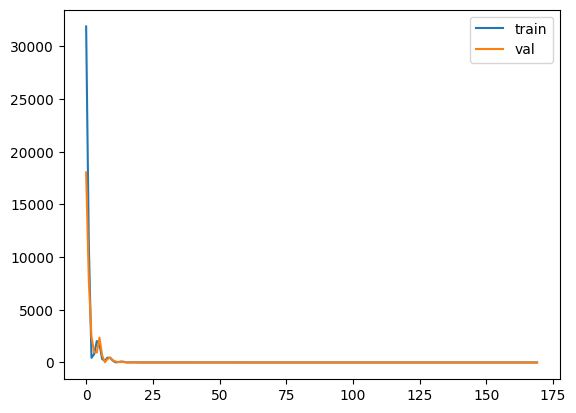

In [30]:
linreg_trainer = Trainer(
    LinearRegression(),
    ModelingDataset(train_dataset, val_dataset),
    lambda _: nn.MSELoss(),
    lambda h, model: torch.optim.SGD(model.parameters(), lr=h["learning_rate"], momentum=h["momentum"]),
    {
        "batch_size": 30,
        "num_epochs": 10,
        "learning_rate": 2e-3,
        "momentum": 0.9
    }
)
linreg_trainer.train(4)

In [32]:
linreg_trainer.model.parameters()

<generator object Module.parameters at 0x7f285cf4a120>